In [1]:
import torch
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc
matplotlib.rcParams['figure.dpi'] = 150
f_path = "/System/Library/Fonts/Helvetica.ttc"
font_name = fm.FontProperties(fname=f_path).get_name()
rc('font', family=font_name, size=13)


import matplotlib.pyplot as plt
from sentence_transformers import models, SentenceTransformer
from collections import defaultdict
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

from scipy.stats import binned_statistic

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

### Load data, user belief embeddings

In [2]:
data_indices = [0,1,2,3,4]
model_types = ['model_bert_ft', 'model_roberta-base_ft', 'model_bert', 'model_roberta-base']#, 'model_sbert_ft', 'model_sbert'
model_labels = ['Finetuned BERT', 'Finetuned S-BERT', 'BERT', 'S-BERT'] #, 'Finetuned SBERT roberta', 'SBERT roberta'

In [3]:
def get_accuracy(y,y_hat):
    is_same = (y==y_hat)
    acc = sum(is_same)/len(is_same)
    return acc

def get_f1_score(y, y_hat):
    return f1_score(y, y_hat, average='macro')

In [4]:
model_type = model_types[1] #Focus on S-BERT        

df_samples = []

for data_idx in range(0,5):
    df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe_nodup/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))
    df_samples.append(df_sample)
    

In [6]:
user2belief_vecs = {}
for data_idx in range(0,5):
    user2belief_vecs[data_idx] = {}
    with open('../dataset/UserEmbeddings/user2beliefvectors_data(%d)_model(model_roberta-base_ft).p'%(data_idx), 'rb') as f:
        user2belief_vecs[data_idx] = pickle.load(f)

In [5]:
df_samples[0].head()

,debate_key,debate_title,username,debate_date,position,is_belief,belief_statement,votelen,predicted_outcome,true_outcome,d_min,d_max,d_avg,d_rel,majority_pred,random_pred,majority_pred_group
1,.-Audis-are-junkers-except-to-rich-kids-with-l...,". Audis are junkers, except to rich kids with ...",Max.Wallace,2014-09-04,Pro,1.0,I agree with the following: . Audis are junker...,141,True,True,20.327677,36.096668,28.212173,0.775740,True,1,False
2,....-Former-Secretary-of-State-Madeleine-Albri...,"....""Former Secretary of State Madeleine Albri...",Lookingatissues,2017-01-30,Pro,1.0,"I agree with the following: ....""Former Secret...",29,True,True,19.105051,37.939125,28.522087,0.985816,True,0,False
4,.9-repeated-is-equal-to-1./1/,.9 repeated is equal to 1.,cowpie1998,2011-04-07,Pro,1.0,I agree with the following: .9 repeated is equ...,1,True,True,33.669617,37.313919,35.491768,0.108237,True,1,False
5,.99-is-equal-to-one./1/,.99 is equal to one.,SweetCrackerJack,2013-12-24,Pro,1.0,I agree with the following: .99 is equal to one.,6,False,True,28.006861,31.512686,29.759773,0.125177,True,0,False
7,.999-repeating-is-equal-to-1-in-reality/1/,.999 repeating is equal to 1 in reality,batman,2008-01-05,Pro,1.0,I agree with the following: .999 repeating is ...,4,True,True,27.081041,30.997705,29.039373,0.144628,True,0,False


### Radius of gyration

In [7]:
user2rms_list = [] #radius of gyration for each data_idx
user2history_list = [] #vote length for each data_idx

for data_idx in range(5):
    
    user2vecs = user2belief_vecs[data_idx]  
    user2history = {} #vote length
    user2rms = {} #user: radius of gyration
    
    for user in user2vecs:        
        user2history[user] = len(user2vecs[user])
        
        vecs = [] 
        for v in user2vecs[user]:
            vecs.append(v)
        vecs = np.array(vecs)
        
        if len(vecs) == 1:
            user2rms[user] = 0
            continue
        
        mean_vec = vecs.mean(axis=0)
        diffs = vecs - mean_vec
        square = np.linalg.norm(diffs, axis=1)**2

            
        mean_square = square.sum()/len(square)
        rms = np.sqrt(mean_square)
        user2rms[user] = rms
        
        
    user2rms_list.append(user2rms)
    user2history_list.append(user2history)

### Add radius to dataframe

In [9]:
for data_idx in range(5):
    df_samples[data_idx]['radius'] = df_samples[data_idx]['username'].map(user2rms_list[data_idx])

In [41]:
def get_color(ratio, cmap='viridis'):
    cmap = plt.get_cmap(cmap)
    return cmap(ratio)  # Get RGBA color
    #return matplotlib.colors.rgb2hex(color)

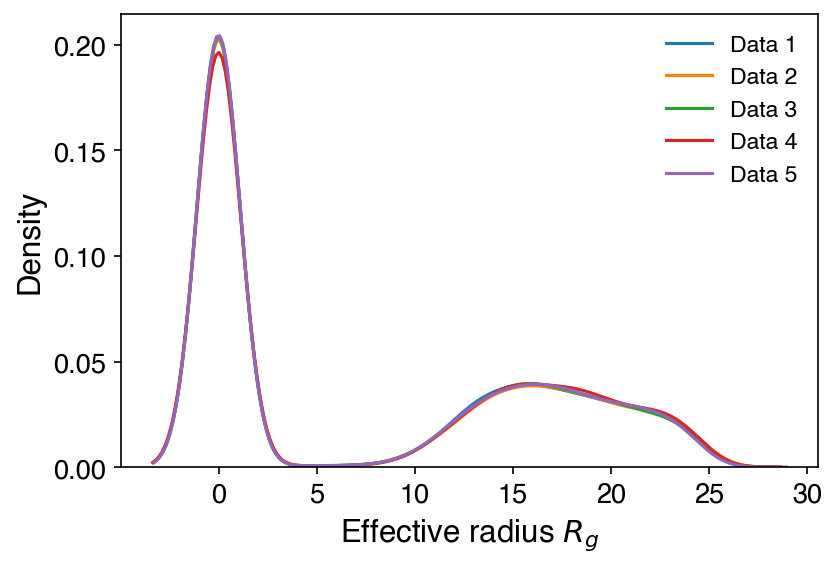

In [189]:
plt.figure()

for data_idx in range(5):

    radius = [e for e in user2rms_list[data_idx].values()]
    
    sns.kdeplot(radius,  label='Data %d'%(data_idx+1))
    
plt.xlabel(r'Effective radius $R_g$', fontsize=15)
plt.ylabel(r'Density', fontsize=15)
plt.legend(frameon=False, fontsize=13)
plt.legend(frameon=False, fontsize=11)
    
plt.savefig('../fig/effective_radius/radius_distribution.pdf', transparent=True, bbox_inches='tight')
plt.show()        



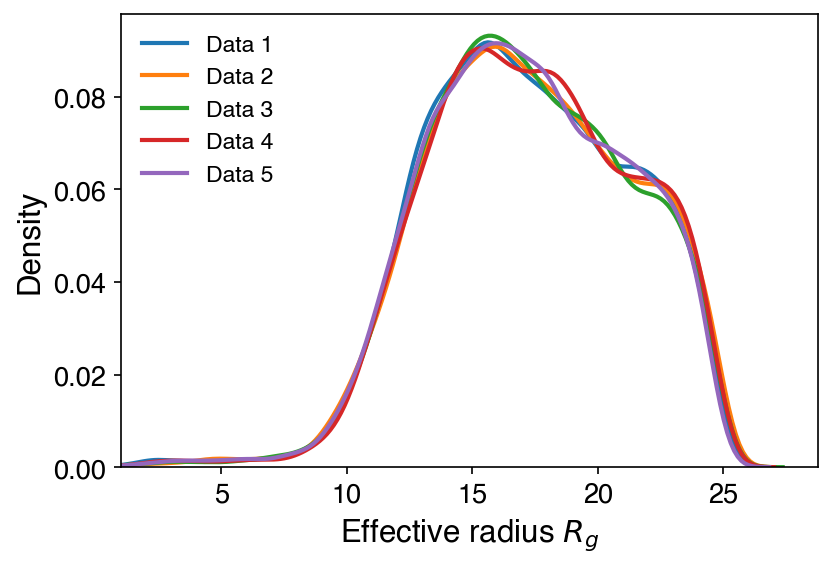

In [188]:
plt.figure()

for data_idx in range(5):

    radius = [e for e in user2rms_list[data_idx].values() if e > 0]
    
    sns.kdeplot(radius, lw=2, label='Data %d'%(data_idx+1))
    
plt.xlabel(r'Effective radius $R_g$', fontsize=15)
plt.ylabel(r'Density', fontsize=15)
plt.legend(frameon=False, fontsize=11)
plt.xlim(1,)

plt.savefig('../fig/effective_radius/radius_distribution_except1.pdf', transparent=True, bbox_inches='tight')
plt.show()        

### Group by voter 

In [160]:
df_samples[0].head(1)

,debate_key,debate_title,username,debate_date,position,is_belief,belief_statement,votelen,predicted_outcome,true_outcome,d_min,d_max,d_avg,d_rel,majority_pred,random_pred,majority_pred_group,radius
1,.-Audis-are-junkers-except-to-rich-kids-with-l...,". Audis are junkers, except to rich kids with ...",Max.Wallace,2014-09-04,Pro,1.0,I agree with the following: . Audis are junker...,141,True,True,20.327677,36.096668,28.212173,0.77574,True,1,False,20.331857


In [57]:
df_rms_list = []

for idx in range(5):
    
    df_ = df_samples[idx]
    
    user_accs = []
    user_rmss = []
    user_history = []
    user_name = []

    for g, dat in df_.groupby('username'):
        user_acc = get_accuracy(dat['predicted_outcome'], dat['true_outcome'])
        user_accs.append(user_acc)
        
        user_rmss.append(dat['radius'].iloc[0])
        user_history.append(dat['votelen'].iloc[0])
        user_name.append(g)

    df_rms = pd.DataFrame({'user':user_name, 'acc':user_accs, 'radius':user_rmss, 'history':user_history})
    df_rms_list.append(df_rms)

/var/folders/r8/jdw1p2tj6jn34wf676kcsw_r0000gn/T/ipykernel_43653/1717652780.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_std  = df_.groupby(binning).std()
/var/folders/r8/jdw1p2tj6jn34wf676kcsw_r0000gn/T/ipykernel_43653/1717652780.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_std  = df_.groupby(binning).std()
/var/folders/r8/jdw1p2tj6jn34wf676kcsw_r0000gn/T/ipykernel_43653/1717652780.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which

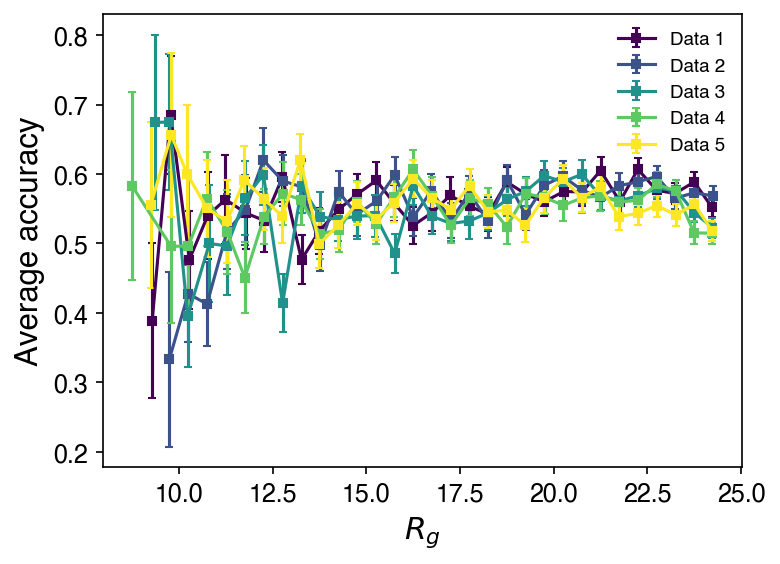

In [172]:
colors = [get_color(i/4, 'viridis') for i in range(5)]

plt.figure(figsize=(5.5,4))

for idx in range(5):
    
    df_ = df_rms_list[idx]
    binning = pd.cut(df_['radius'], bins=np.arange(1,25,0.5))
    
    df_mean = df_.groupby(binning).mean('acc')
    df_std  = df_.groupby(binning).std()
    df_std['count']  = df_.groupby(binning)['radius'].count()
    over_thres = df_.groupby(binning)['radius'].count()>=10
    
    
    df_mean['over_thres'] = over_thres
    df_std['over_thres']  = over_thres
    
    df_std['std_err'] = df_std['acc']/np.sqrt(df_std['count'])
    
    df_mean = df_mean[df_mean['over_thres']==True]
    df_std = df_std[df_std['over_thres']==True]
    

    #plt.plot(df_mean['rms'], df_mean['acc'], 's-', ms=6, color=colors[idx], label='Data %d'%(idx+1)) 
    plt.errorbar(x=df_mean['radius'], y=df_mean['acc'], yerr=df_std['std_err'], marker='s',
                 capsize=2, ms=4, color=colors[idx], label='Data %d'%(idx+1)) 
    
plt.xlabel(r'$R_g$', fontsize=15)
plt.ylabel('Average accuracy', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=False, fontsize=9, loc=1)
plt.savefig('../fig/effective_radius/radius_vs_acc.pdf', transparent=True, bbox_inches='tight')
plt.show()        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


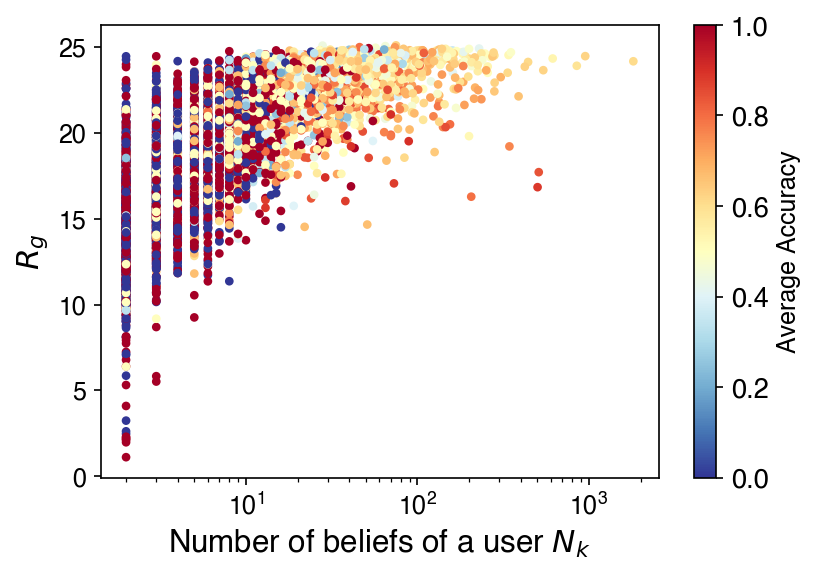

In [184]:
plt.figure(figsize=(6,4))

df_ = df_rms_list[0]
df_ = df_[df_['radius']>0]
cm = plt.cm.get_cmap('RdYlBu_r')
#cm = plt.cm.get_cmap('viridis_r')
ax = plt.scatter(df_['history'], df_['radius'], s=10, c=df_['acc'], cmap=cm)

plt.xscale('log')
plt.ylabel(r'$R_g$', fontsize=15)
plt.xlabel(r'Number of beliefs of a user $N_k$', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=False, fontsize=9, loc=1)

partitions = np.arange(20,100,20)
#plt.axvline(x=10, color='gray', alpha=0.8, ls='--', zorder=0)
#for p in partitions:
#    plt.axvline(x=p, color='gray', alpha=0.8, ls='--', zorder=0)

cbar = plt.colorbar(ax)
cbar.set_label(label="Average Accuracy", fontsize=12)
plt.savefig('../fig/effective_radius/task1_Radius_vs_history_Avgacc(0-100).pdf', transparent=True)
plt.show()        


In [108]:
df_part = df_rms_list[0].copy()

len(df_part)

df_low = df_part[(10<df_part['history']) & (df_part['history']<=20)]
df_middle1 = df_part[(20<df_part['history']) & (df_part['history']<=40)]
df_middle2 = df_part[(40<df_part['history']) & (df_part['history']<=60)]
df_high = df_part[(60<df_part['history']) & (df_part['history']<80)]
df_high2 = df_part[(80<df_part['history'])]

len(df_low), len(df_middle1), len(df_middle2), len(df_high), len(df_high2)


(1119, 632, 210, 119, 183)

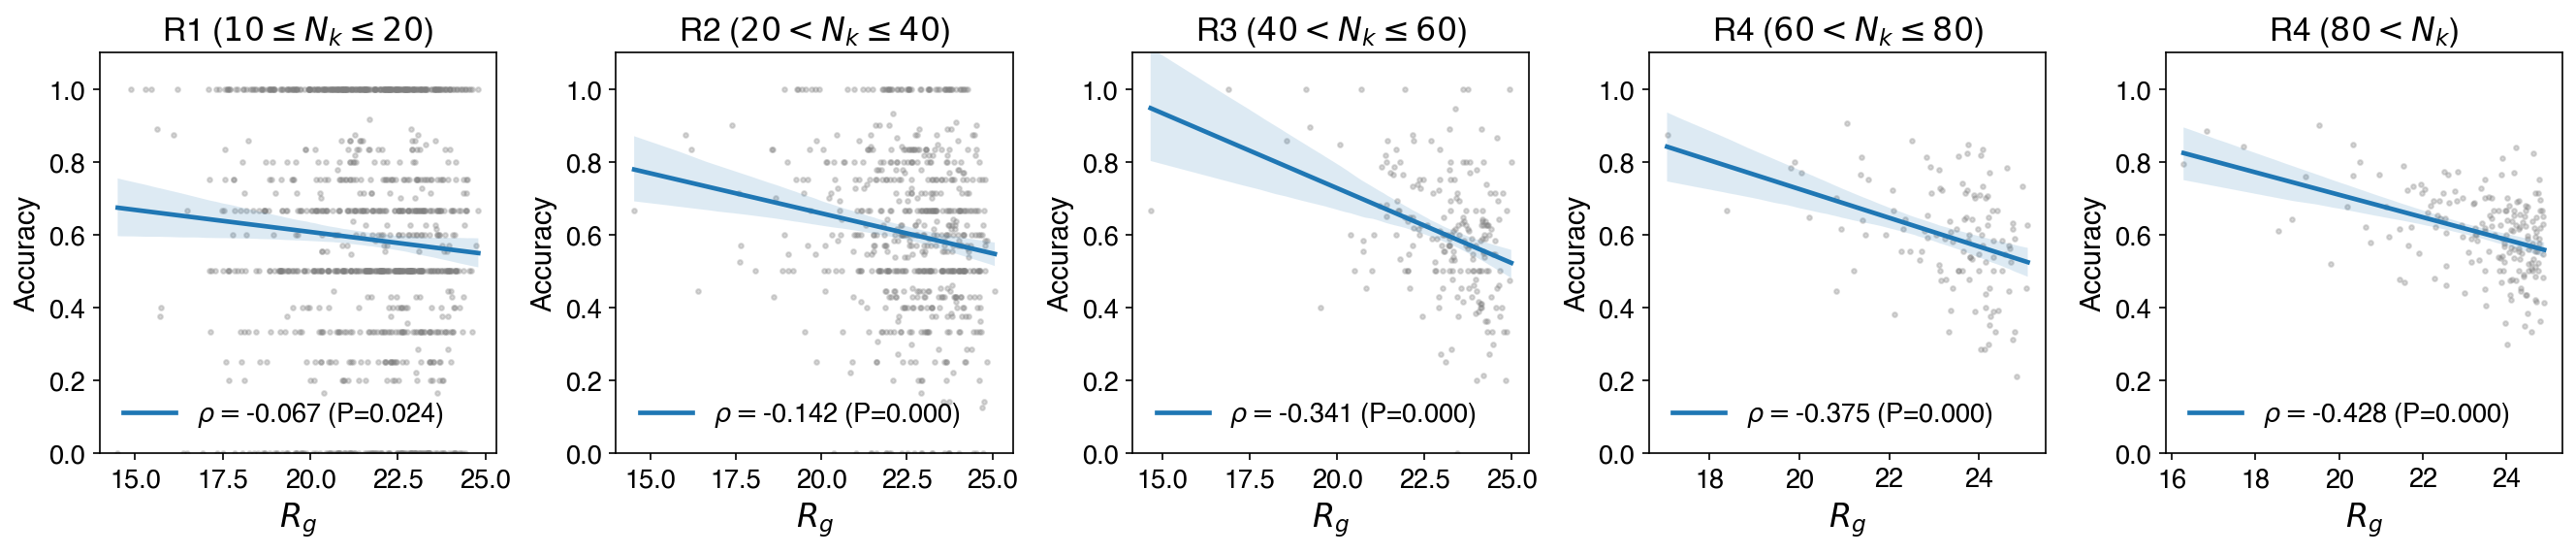

In [181]:
from scipy.stats import pearsonr

dfs = [df_low, df_middle1, df_middle2, df_high, df_high2]
titles = [r'R1 ($10\leq N_k\leq 20$)', r'R2 ($20 < N_k \leq40$)',r'R3 ($40 < N_k \leq 60$)', r'R4 ($60 < N_k \leq 80 $)', r'R4 ($80 < N_k$)']

fig, axes = plt.subplots(1,5, figsize=(18,4))

for i in range(5):
    ax=axes[i]
    r,p = pearsonr(dfs[i]['radius'], dfs[i]['acc'])
    ax.scatter(dfs[i]['radius'], dfs[i]['acc'], s=5, color='gray', alpha=0.3)
    sns.regplot(data=dfs[i], x='radius', y='acc', scatter=0,  ax=ax, label=r'$\rho=$%.3f (P=%.3f)'%(r, p))
    
    
    ax.set_title(
        titles[i], fontsize=16)
    ax.set_xlabel(r'$R_g$', fontsize=16)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.legend(frameon=False, loc=3)
    ax.set_ylim(bottom=0, top=1.1)
    
plt.tight_layout()
plt.savefig('../fig/effective_radius/task1_Radius_vs_Avgacc_crosssection.png', dpi=200, transparent=True)